<a href="https://colab.research.google.com/github/ulewis/FdD/blob/main/Balanceo%20ROS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importamos librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Extraemos datos
data='para volumen 4ta vuelta.csv'

In [3]:
#visualizamos el dataset
df= pd.read_csv(data)
df.head()

,C,Rp,Dif_vol,V_in,V_out,P_ventilador,PIP,Error_aceptable
0,20,20,-2.7,350,352.7,27.6,25.5,1
1,20,20,-4.7,350,354.7,30.3,30.2,1
2,20,20,1.2,350,348.8,32.0,33.0,1
3,20,20,3.1,400,396.9,30.3,29.4,1
4,20,20,-7.0,400,407.0,33.9,34.3,1


In [4]:
#Revisamos dimension de la data
df.shape

(69, 8)

In [5]:
#filtramos decartando columnas con datos faltantes
d_filtrado = df.dropna().copy() 

In [6]:
#Verificamos cuantos valores tenemos de Rp
d_filtrado.V_out.unique()

array([352.7, 354.7, 348.8, 396.9, 407. , 401.6, 442.2, 455.5, 451.2,
       482.2, 492. , 494.5, 541.7, 549.6, 558.5, 597.3, 599. , 612.5,
       327.8, 307.5, 303.2, 375. , 360.8, 358.6, 419.6, 408.8, 407.5,
       455.2, 457.3, 461.5, 518.2, 515.8, 524.4, 574. , 571.6, 296.8,
       281.3, 277.5, 335.2, 332.8, 330.7, 382. , 377. , 383. , 436.4,
       429.6, 436.5, 498.1, 496.1, 499.6, 552. , 548.8, 269. , 302.6,
       302.7, 303. , 344.1, 344.2, 389.1, 396.6, 386.5, 435.7, 452.7,
       487.9, 509.7, 527. , 544.5, 559.9])

In [7]:
#revisamos de la data filtrada
d_filtrado.shape

(69, 8)

In [8]:
#contar valores
d_filtrado['Error_aceptable'].value_counts()

1    53
0    16
Name: Error_aceptable, dtype: int64

In [9]:
#revisamos proporción
d_filtrado['Error_aceptable'].value_counts()/len(d_filtrado)

1    0.768116
0    0.231884
Name: Error_aceptable, dtype: float64

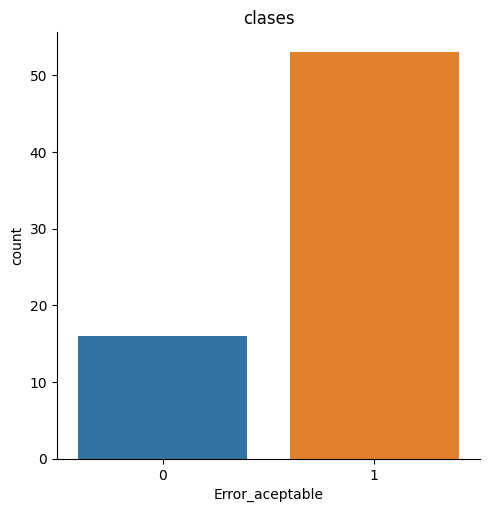

In [10]:
#observamos el desbalance de datos
p=sns.catplot(data = d_filtrado, kind ='count', x= 'Error_aceptable')
p.set(title = "clases")

In [11]:
# definimos la matriz de caracteristicas
x = d_filtrado.loc[:,['P_ventilador','PIP']]
y = d_filtrado['Error_aceptable']

In [12]:
print(len(y[y==0]))
print(len(y[y==1]))

16
53


In [13]:
#divimos la data en conjunto de entranimiento y test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state = 0)
print(len(x_train),len(x_test))

51 18


In [14]:
print(len(y_train[y_train==0]))
print(len(y_train[y_train==1]))


11
40


In [15]:
# Estandarización de características
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [16]:
print(df.head())

    C  Rp  Dif_vol  V_in  V_out  P_ventilador   PIP  Error_aceptable
0  20  20     -2.7   350  352.7          27.6  25.5                1
1  20  20     -4.7   350  354.7          30.3  30.2                1
2  20  20      1.2   350  348.8          32.0  33.0                1
3  20  20      3.1   400  396.9          30.3  29.4                1
4  20  20     -7.0   400  407.0          33.9  34.3                1


REGRESIÓN LOGISTICA

In [17]:
from sklearn.linear_model import LogisticRegression
regLog = LogisticRegression(random_state = 0)
regLog.fit(x_train,y_train)

LogisticRegression(random_state=0)

In [18]:
# Se anñade una columna constante para el término de intercepción
x_train_with_const = sm.add_constant(x_train)

# Crear un modelo logístico con statsmodels
logit_model = sm.Logit(y_train, x_train_with_const)

# Ajustar el modelo
result = logit_model.fit()

# Obtener los coeficientes y los p-valores
coefficients = result.params
p_values = result.pvalues

print("Coeficientes:")
print(coefficients)
print("\nP-valores:")
print(p_values)

Optimization terminated successfully.
         Current function value: 0.484023
         Iterations 6
Coeficientes:
const    1.444070
x1       0.113208
x2       0.650886
dtype: float64

P-valores:
const    0.000207
x1       0.908931
x2       0.497941
dtype: float64


In [46]:
score = regLog.score(x_test, y_test,)
round(score,4)

0.7222

In [47]:
y_pred = regLog.predict(x_test)

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         5
           1       0.72      1.00      0.84        13

    accuracy                           0.72        18
   macro avg       0.86      0.50      0.42        18
weighted avg       0.80      0.72      0.61        18



In [22]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 0  5]
 [ 0 13]]


In [23]:
pd.crosstab(y_test,y_pred)

col_0,1
Error_aceptable,
0,5
1,13


In [24]:
# K-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regLog, X = x_train, y=y_train, cv= 10)
accuracies.mean()

0.7866666666666667

In [25]:
accuracies

array([0.66666667, 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 0.8       ])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


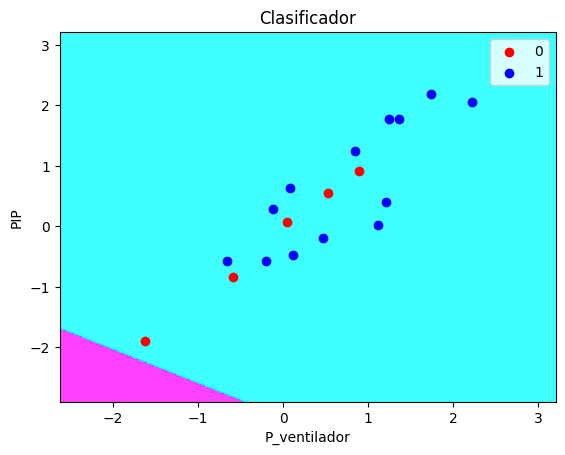

In [26]:
# Creamos un plot para ver la frontera de clasificación

from matplotlib.colors import ListedColormap
x_set, y_set = x_test, y_test
X1,X2 = np.meshgrid(np.arange(start = x_set[:,0].min()-1,stop = x_set[:,0].max()+1,step=0.01),
                    np.arange(start = x_set[:,1].min()-1,stop = x_set[:,0].max()+1,step=0.01))
plt.contourf(X1,X2, regLog.predict(np.array([X1.ravel(),X2.ravel()]).T).reshape(X1.shape),
             alpha=0.75, cmap = ListedColormap(('magenta', 'cyan')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i,j in enumerate(np.unique(y_set)):
    plt.scatter(x_set[y_set == j,0],x_set[y_set== j,1],
                c = ListedColormap(('red','blue'))(i),label = j)
    
plt.title('Clasificador')
plt.xlabel('P_ventilador')
plt.ylabel('PIP')
plt.legend()
plt.show()



**Balanceo ROS**

In [27]:
len(x_train)

51

In [28]:
train = np.concatenate([x_train, y_train.values.reshape(-1,1)], axis=1)

In [29]:
#transformamos a un dataFrame
train = pd.DataFrame(train,columns=['P_ventilador','PIP','Error_aceptable'])

In [30]:
#obtenemos la clase con error que no se acepta
train_class_0 = train.query("Error_aceptable == 0")
train_class_0.head()

,P_ventilador,PIP,Error_aceptable
10,0.223825,0.439871,0.0
12,0.960943,1.027543,0.0
13,-0.779474,-1.064570,0.0
16,-1.363025,-1.691421,0.0
20,-0.984229,-0.845173,0.0


In [31]:
train_class_0.shape

(11, 3)

In [32]:
n_class0 = len(train.query("Error_aceptable == 0"))
n_class1 = len(train.query("Error_aceptable == 1"))
print ( n_class0, n_class1)

11 40


In [33]:
i_class0_downsampled = train_class_0.sample(n_class1,replace = True)
len(i_class0_downsampled)

40

In [34]:
new_train = pd.concat([train.query("Error_aceptable == 1"), i_class0_downsampled], axis=0)
new_train[['Error_aceptable']].value_counts()

Error_aceptable
0.0                40
1.0                40
dtype: int64

In [35]:
new_x_train =new_train.loc[:,['P_ventilador','PIP']].values
new_y_train =new_train.loc[:,['Error_aceptable']].values


In [36]:
new_y_train = pd.Series(new_y_train.reshape(-1,))

In [37]:
new_train.loc[:,['Error_aceptable']].value_counts()

Error_aceptable
0.0                40
1.0                40
dtype: int64

Nuevo modelo con nueva data

In [38]:
model= LogisticRegression()
model. fit(new_x_train, new_y_train)

LogisticRegression()

In [39]:
y_pred2 = model.predict(x_test)

In [53]:
print(classification_report(y_test, y_pred,zero_division=1))
print(classification_report(y_test, y_pred2,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         5
           1       0.72      1.00      0.84        13

    accuracy                           0.72        18
   macro avg       0.86      0.50      0.42        18
weighted avg       0.80      0.72      0.61        18

              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.79      0.85      0.81        13

    accuracy                           0.72        18
   macro avg       0.64      0.62      0.63        18
weighted avg       0.71      0.72      0.71        18

